In [1]:
import os
from os.path import join
import mlflow

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytorch_lightning as pl

from src.dyslexia_dataloader import DyslexiaDataModule
from src.dyslexia_training_module import DyslexiaTrainingModule

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [2]:
DATA_PATH = join("..", "data")
IMAGES_DIR_NAME = "dyslexia_images_big"

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Utility Functions

In [4]:
def show_loss_graph(experiment_id, run_id, save_path: str = join("..", "logging", "plots")):
    metrics_path = join("mlruns", str(experiment_id), run_id, "metrics")
    
    fig, ax = plt.subplots(figsize=(10, 6))
    stages = ("train", "val")
    losses = ("loss",)
    for stage in stages:
        for loss in losses:
            name = f'{stage}_{loss}_epoch'
            path = join(metrics_path, name)
            values = pd.read_csv(path, delimiter=' ').to_numpy()
            
            ax.plot(values[:, 2].flatten(), values[:, 1].flatten(), label=name)
        
    ax.legend()
    ax.set(title="Model performance", xlabel="Epoch", ylabel="Loss")
    
    if not os.path.exists(save_path):
        os.mkdir(save_path)  
    fig.savefig(os.path.join(save_path, f"training_plot_{experiment_id}_{run_id}"))

In [5]:
def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    return inp

### MLFLOW Setup

In [6]:
run = None

EXPERIMENT_NAME = "dyslexia_cnn"
RUN_ID = None
MLFLOW_LOGGING_PATH = join("..", "logging", "mlruns")

if mlflow.get_experiment_by_name(EXPERIMENT_NAME) is None:
    EXPERIMENT_ID = mlflow.create_experiment(EXPERIMENT_NAME, artifact_location=MLFLOW_LOGGING_PATH)
else:
    EXPERIMENT_ID = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

### Hyperparameters

In [7]:
BATCH_SIZE  = 64
MAX_EPOCHS  = 30
NUM_CLASSES = 2
PATIENCE    = 10

WIDTH = HEIGHT = IMG_SIZE = 50

### Dataset

In [8]:
IMAGE_ID = 1

In [9]:
data_module_small = DyslexiaDataModule(
    batch_size=BATCH_SIZE,
    data_path=DATA_PATH,
    train_frac=0.85,
    val_frac=0.10,
    width=WIDTH,
    height=HEIGHT,
    images_dir_name="dyslexia_images_small"
)

In [10]:
data_module_big = DyslexiaDataModule(
    batch_size=BATCH_SIZE,
    data_path=DATA_PATH,
    train_frac=0.85,
    val_frac=0.10,
    width=WIDTH,
    height=HEIGHT,
    images_dir_name="dyslexia_images_big"
)

In [11]:
import cv2

def get_image(path: str):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def show_images(image_id: int = IMAGE_ID):
    image_name       = data_module_small.ds_train.group_ids[image_id] + ".png"
    image_path_small = join(DATA_PATH, "dyslexia_images_small", image_name)
    image_path_big   = join(DATA_PATH, "dyslexia_images_big", image_name)
    image_real_small = get_image(image_path_small)
    image_real_big   = get_image(image_path_big)
    image_res_small  = data_module_small.ds_train[image_id][0]
    image_res_big    = data_module_big.ds_train[image_id][0]

    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 6))
    axes[0, 0].imshow(image_real_small)
    axes[0, 0].set(title="Real scanpath    ('small' paths)")
    axes[0, 1].imshow(image_real_big)
    axes[0, 1].set(title="Real scanpath    ('big' paths)")
    axes[1, 0].imshow(reverse_transform(image_res_small))
    axes[1, 0].set(title="Resized scanpath ('small' paths)")
    axes[1, 1].imshow(reverse_transform(image_res_big))
    axes[1, 1].set(title="Resized scanpath ('big' paths)")
    fig.tight_layout()

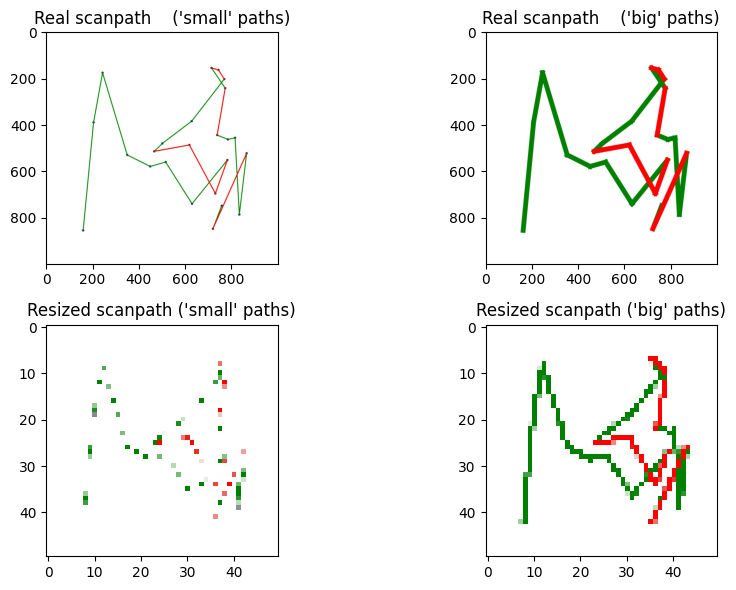

In [12]:
show_images(3)

In [14]:
pd.DataFrame(data={
    "ResNet": {
        "f1": 0.67,
        "precision": 0.70,
        "recall": 0.67
    },
    "CNN": {
        "f1": 0.61,
        "precision": 0.67,
        "recall": 0.61
    }
}).T

,f1,precision,recall
ResNet,0.67,0.70,0.67
CNN,0.61,0.67,0.61
